In [5]:
import cv2
import numpy as np
from time import *
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.cluster import DBSCAN

videoName = 'data/30 step.avi'
name=videoName.split('/')[-1].split('.')[0]
cap = cv2.VideoCapture(videoName)
ret, frame = cap.read()
height, width, channel = frame.shape
fps = cap.get(cv2.CAP_PROP_FPS)
delay = 1/fps
t1=0
t2=0
frame1=0
frame2=0
startPoint = (-1, -1)
endPoint = (-1, -1)
paused = False  # Variable to toggle pause state
drawing = False
mouseInstance = False
track = True
grayFrame = None
roi = None
roiW = 0
roiH = 0
confidence=0.01
datax=[]
datay=[]
grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
_, grayFrame = cv2.threshold(grayFrame, 128, 255, cv2.THRESH_BINARY)
roiW = int(width*0.2)
roiH = int(height*0.2)
topLeft = ((width - roiW) // 2, (height - roiH) // 2)
bottomRight = (topLeft[0] + roiW, topLeft[1] + roiH)
roi = grayFrame[topLeft[1]:bottomRight[1], topLeft[0]:bottomRight[0]]
roiRect=(topLeft,bottomRight)

class ClusterFilter:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps  # Maximum distance between two samples for them to be considered in the same neighborhood
        self.min_samples = min_samples  # Minimum number of points to form a cluster

    def apply_dbscan(self, x_data, y_data):
        # Combine x and y data for clustering
        data = np.vstack((x_data, y_data)).T

        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        labels = dbscan.fit_predict(data)

        # Filter out noise (label == -1)
        cluster_mask = labels != -1
        noise_mask = labels == -1

        clustered_x = x_data[cluster_mask]
        clustered_y = y_data[cluster_mask]

        noise_x = x_data[noise_mask]
        noise_y = y_data[noise_mask]

        return clustered_x, clustered_y, noise_x, noise_y

# Mouse callback function to draw rectangle
def drawRectangle(event, x, y, flags, param):
    global startPoint, endPoint, drawing, mouseInstance

    # On left mouse button down, start drawing the rectangle
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        mouseInstance = True
        startPoint = (x, y)

    # On mouse move, update the end point of the rectangle if drawing is in progress
    elif event == cv2.EVENT_MOUSEMOVE and drawing and mouseInstance:
        endPoint = (x, y)

    # On left mouse button up, finalize the rectangle
    elif event == cv2.EVENT_LBUTTONUP:
        mouseInstance = False
        endPoint = (x, y)
        cv2.rectangle(frame, startPoint, endPoint, (0, 255, 0), 2)

def textBackground(text, fontScale, thickness, pos):
    (textWidth, textHeight), baseline = cv2.getTextSize(str(text), cv2.FONT_HERSHEY_SIMPLEX, fontScale, thickness)
    rect = [(pos[0], pos[1]), (pos[0] + textWidth, pos[1] + textHeight+baseline)]
    textPos = (pos[0], pos[1] + textHeight + baseline // 2)
    
    return (rect, textPos)

def drawROI(frame, frameCount, topLeft, bottomRight, maxVal, color, text):
    cv2.rectangle(frame, topLeft, bottomRight, color, 2)
    msgConf = f'Confidence : {maxVal:.3f}'
    posConf=(5, 60) 
    fontScale = 1.5
    thickness = 2
    rectConf, posConf = textBackground(msgConf, fontScale, thickness, posConf)
    cv2.rectangle(frame, rectConf[0], rectConf[1], color=(255, 255, 255), thickness=-1)
    cv2.putText(frame, msgConf, posConf, cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0,0,0), thickness, lineType=cv2.LINE_AA)
    cv2.putText(frame, text, (topLeft[0],topLeft[1]+30), cv2.FONT_HERSHEY_SIMPLEX, fontScale, color, thickness, lineType=cv2.LINE_AA)
    
    roi_center_x = (topLeft[0] + bottomRight[0]) // 2
    roi_center_y = (topLeft[1] + bottomRight[1]) // 2

    datax.append((frameCount, roi_center_x))
    datay.append((frameCount, roi_center_y))

# Create a window and set a mouse callback to the window
cv2.namedWindow(videoName)
cv2.setMouseCallback(videoName, drawRectangle)

def preCheck(search_region, roi, threshold=0.05, scale=0.1):
    reducedRegion = cv2.resize(search_region, (0, 0), fx=scale, fy=scale)
    reducedROI = cv2.resize(roi, (0, 0), fx=scale, fy=scale)

    res = cv2.matchTemplate(reducedRegion, reducedROI, cv2.TM_SQDIFF_NORMED)
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
    
    if minVal <= threshold:
        return True, 1 / (1 + np.abs(minVal))
    else:
        return False, 1 / (1 + np.abs(minVal))

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frameCount = cap.get(cv2.CAP_PROP_POS_FRAMES)
        if drawing and not track:
            cv2.rectangle(frame, startPoint, endPoint, (0, 0, 255), 2)

        if track:
            grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Update gray frame
            _, grayFrame = cv2.threshold(grayFrame, 128, 255, cv2.THRESH_BINARY)
            
            # Ensure the current ROI size is smaller than the frame size
            if roi is not None and grayFrame.shape[0] >= roi.shape[0] and grayFrame.shape[1] >= roi.shape[1] and bottomRight and topLeft:
                expand_size = 50
                search_topLeft_x = max(topLeft[0] - expand_size, 0)
                search_topLeft_y = max(topLeft[1] - expand_size, 0)
                search_bottomRight_x = min(bottomRight[0] + expand_size, grayFrame.shape[1])
                search_bottomRight_y = min(bottomRight[1] + expand_size, grayFrame.shape[0])
                search_region = grayFrame[search_topLeft_y:search_bottomRight_y, search_topLeft_x:search_bottomRight_x]
                cv2.rectangle(frame, (search_topLeft_x,search_topLeft_y), (search_bottomRight_x,search_bottomRight_y), color=(255, 0, 255), thickness=2)
                cv2.putText(frame, 'search_region', (search_topLeft_x,search_topLeft_y-5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), 2, lineType=cv2.LINE_AA)
                cv2.rectangle(frame, roiRect[0], roiRect[1], color=(255, 255, 0), thickness=2)
                cv2.putText(frame, 'roi', (roiRect[0][0], roiRect[0][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 2, lineType=cv2.LINE_AA)
                
                # Perform template matching in the smaller region
                searched = False
                framed = False
                framedVal=0
                searchVal=0
                if search_region.shape[0] >= roi.shape[0] and search_region.shape[1] >= roi.shape[1]:
                    searched, searchVal = preCheck(search_region, roi)
                    if searched:
                        cv2.putText(frame, f's: {searchVal:.3f}', (roiRect[0][0],roiRect[1][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 2, lineType=cv2.LINE_AA)
                    else:
                        framed, framedVal = preCheck(grayFrame, roi)
                        if framed:
                            cv2.putText(frame, f's: {searchVal:.3f}, f: {framedVal:.3f}', (roiRect[0][0],roiRect[1][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 2, lineType=cv2.LINE_AA)
                    if any([searched,framed]):    
                        res = cv2.matchTemplate(search_region, roi, cv2.TM_SQDIFF_NORMED)
                        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
                        val = 1 / (1 + np.abs(minVal))
                        if minVal <= confidence:
                            topLeft = (minLoc[0] + search_topLeft_x, minLoc[1] + search_topLeft_y)
                            bottomRight = (topLeft[0] + roiW, topLeft[1] + roiH)
        
                            if bottomRight[1] <= grayFrame.shape[0] and bottomRight[0] <= grayFrame.shape[1] and minVal <= confidence:
                                color=(0,255,0)
                                text='search'
                                drawROI(frame, frameCount, topLeft, bottomRight, val, color, text)
                        elif minVal <= 0.2: # try frame if search_region fails given some margin
                            res = cv2.matchTemplate(grayFrame, roi, cv2.TM_SQDIFF_NORMED)
                            minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
                            #minVal, minLoc = normalized_fourier_match(search_region, roi)
                            if minVal <= confidence:
                                topLeft = minLoc
                                bottomRight = (topLeft[0] + roiW, topLeft[1] + roiH)
                                val = 1 / (1 + np.abs(minVal))
        
                                if bottomRight[1] <= grayFrame.shape[0] and bottomRight[0] <= grayFrame.shape[1]:
                                    color=(0,0,255)
                                    text='frame'
                                    drawROI(frame, frameCount, topLeft, bottomRight, val, color, text)
                else:
                    print("ROI is too large for the search region.")
        if paused:
            cap.set(cv2.CAP_PROP_POS_FRAMES, pausedFrame)
            
        if frameCount % 2 == 0:
            t2 = time()
            frame2 = cap.get(cv2.CAP_PROP_POS_FRAMES)
        else:
            t1 = time()
            frame1 = cap.get(cv2.CAP_PROP_POS_FRAMES)
        realFPS = np.abs(int(1/(t2 - t1)))
        msgFPS = f'FPS : {realFPS}'
        posFPS=(5, 5) 
        fontScale = 1.5
        thickness = 2
        rectFPS, posFPS = textBackground(msgFPS, fontScale, thickness, posFPS)
        cv2.rectangle(frame, rectFPS[0], rectFPS[1], color=(255, 255, 255), thickness=-1)
        cv2.putText(frame, msgFPS, posFPS, cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0,0,0), thickness, lineType=cv2.LINE_AA)

        cv2.imshow(videoName, frame)

        #sleep(np.abs(1/30))
        key = cv2.waitKey(1)
        currentFrame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        if key == ord('q'):
            break
        elif key == ord(' '):  # Pause/Resume on space bar press
            pausedFrame = currentFrame
            paused = not paused
        elif key == ord('a'):  # Left arrow key (rewind)
            if not paused:
                cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, currentFrame - 30))  # Rewind by 30 frames
            else:
                pausedFrame-=30
        elif key == ord('d'):  # Right arrow key (fast forward)
            if not paused:
                cap.set(cv2.CAP_PROP_POS_FRAMES, currentFrame + 30)  # Fast forward by 30 frames
            else:
                pausedFrame+=30
        elif key == 13:
            if not track:
                grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                roi = grayFrame[startPoint[1]:endPoint[1], startPoint[0]:endPoint[0]]
                roiW, roiH = roi.shape[::-1]
            track = not track
    else:
        break
cap.release()
cv2.destroyAllWindows()

name=videoName.split('/')[-1].split('.')[0]
returnData = dataStatistics(datax, datay, name, kalman=False, mins=False, maxes=False, rawData=True, show_x=True, show_y=True)
distx = clusterizeData(returnData['tx_filter_maxes'], returnData['x_filter_maxes'], returnData['tx_filter_mins'], returnData['x_filter_mins'], returnData['name'])
disty = clusterizeData(returnData['ty_filter_maxes'], returnData['y_filter_maxes'], returnData['ty_filter_mins'], returnData['y_filter_mins'], returnData['name'])
# dists[returnData['name']]=(distx,disty)

NameError: name 'dataStatistics' is not defined

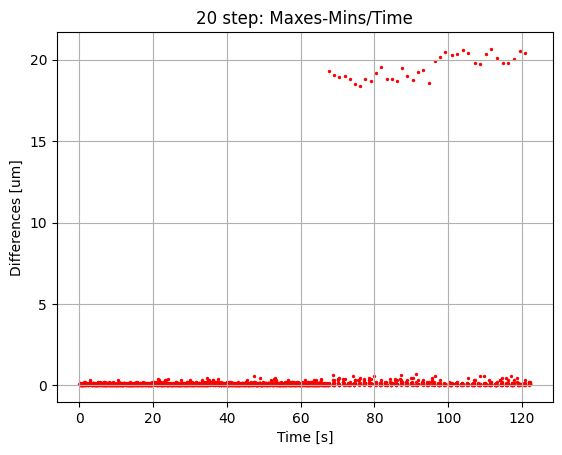

Error: name 'ConvergenceWarning' is not defined4888                                                 
20 step -- Silhouette score for 2 clusters: 0.9958                                                  
20 step -- Trying for 2 clusters. . .

20 step -- Best score of 0.9958 with 2 clusters: 19.4210 um


np.float64(19.42101267719938)

In [42]:
clusterizeData(returnData['ty_filter_maxes'], returnData['y_filter_maxes'], returnData['ty_filter_mins'], returnData['y_filter_mins'], returnData['name'])

C:\Users\Nolan\AppData\Local\Temp\ipykernel_23032\2058837768.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  slope, _ = float(model.coef_), float(model.intercept_)


Text(0.5, 1.0, 'Steps to um Regression')

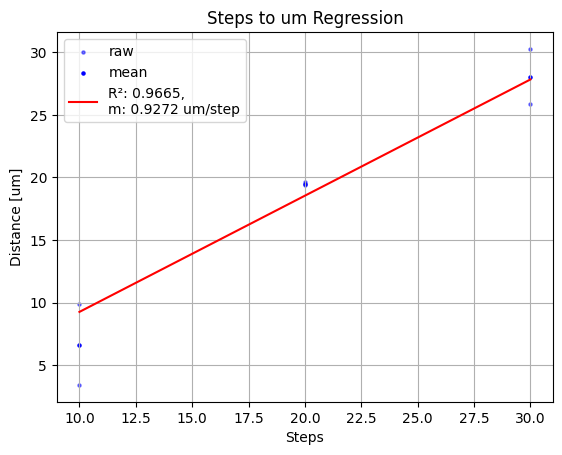

In [276]:
from sklearn.linear_model import LinearRegression

plt.figure()
x=[]
y=[]
z=[]
labels=[]
for step in dists.keys():
    x1, y1 = dists[step]
    x.append(x1)
    y.append(y1)
    z.append(float(step.split(' ')[0]))
    labels.append(step)

x = np.array(x)[np.argsort(z)]
y = np.array(y)[np.argsort(z)]
z = np.array(z)[np.argsort(z)]
plt.scatter(z,x,s=5,color='blue',alpha=0.5,label='raw')
plt.scatter(z,y,s=5,color='blue',alpha=0.5)
mean=np.mean((x,y),axis=0)
plt.scatter(z,mean,s=5,color='blue',label='mean')

mean=mean.reshape(-1, 1)
z=z.reshape(-1, 1)
model = LinearRegression(fit_intercept = False).fit(z, mean)
R2 = model.score(z, mean)
slope, _ = float(model.coef_), float(model.intercept_)
plt.plot(z,z*slope,color='red',label=f'R\u00B2: {R2:.4f},\nm: {slope:.4f} um/step')
plt.legend()

plt.grid()
plt.ylabel('Distance [um]')
plt.xlabel("Steps")
plt.title('Steps to um Regression')

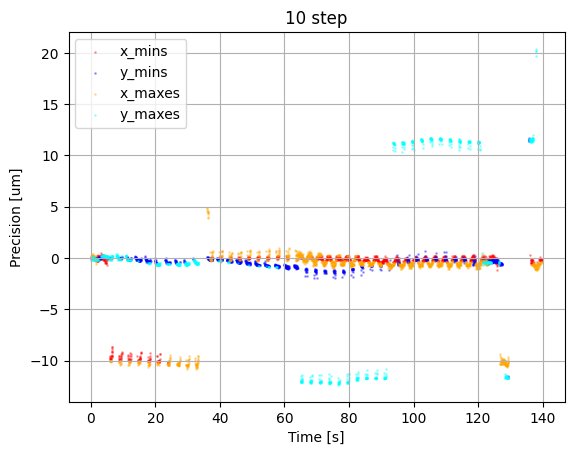

X Precision: +0.03 um, -0.13 um
Y Precision: +0.00 um, -0.32 um


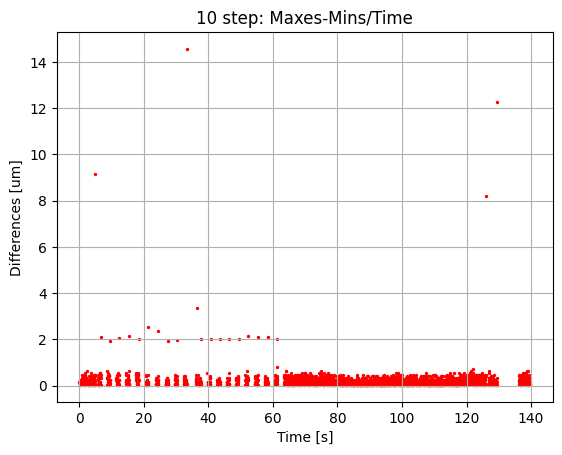

10 step -- Silhouette score for 19 clusters: 0.9942                                                 
10 step -- Trying for 2 clusters. . .
10 step -- Silhouette score for 2 clusters: 0.8237                                                  
10 step -- Best score of 0.8237 with 2 clusters: 10.0063 um


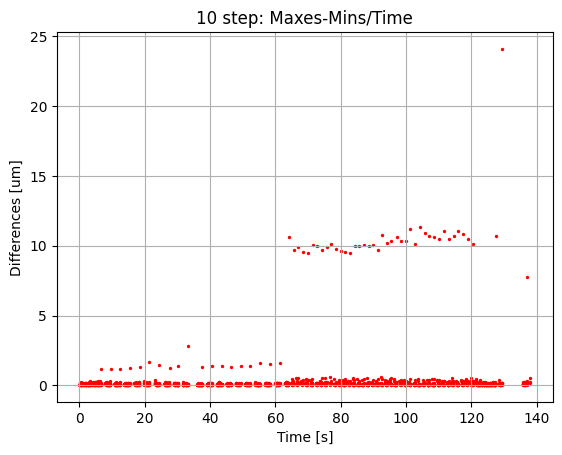

10 step -- Silhouette score for 45 clusters: 0.9904                                                 
10 step -- Trying for 2 clusters. . .
10 step -- Error: Unable to split into two optimal clusters.                                        
10 step -- Best score of 0.8877 with 3 clusters: 
[[ 0.8687329  23.        ]
 [10.20670085 21.        ]
 [24.08356599  1.        ]] um)
10 step -- Selecting two most populous clusters: 0.8687328968369705, 10.206700850790913
10 step -- Estimated Distance: 9.3380 um


In [200]:
name=videoName.split('/')[-1].split('.')[0]
returnData = dataStatistics(datax, datay, name, kalman=False, mins=True, maxes=True, rawData=False, show_x=True, show_y=True)
distx = clusterizeData(returnData['tx_filter_maxes'], returnData['x_filter_maxes'], returnData['tx_filter_mins'], returnData['x_filter_mins'], returnData['name'])
disty = clusterizeData(returnData['ty_filter_maxes'], returnData['y_filter_maxes'], returnData['ty_filter_mins'], returnData['y_filter_mins'], returnData['name'])
dists[returnData['name']]=(distx,disty)

In [9]:
import cv2
import numpy as np
from time import *
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import threading
import psutil
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

class ClusterFilter:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps  # Maximum distance between two samples for them to be considered in the same neighborhood
        self.min_samples = min_samples  # Minimum number of points to form a cluster

    def apply_dbscan(self, x_data, y_data):
        # Combine x and y data for clustering
        data = np.vstack((x_data, y_data)).T

        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        labels = dbscan.fit_predict(data)

        cluster_mask = labels != -1
        noise_mask = labels == -1

        clustered_x = x_data[cluster_mask]
        clustered_y = y_data[cluster_mask]

        noise_x = x_data[noise_mask]
        noise_y = y_data[noise_mask]

        return clustered_x, clustered_y, noise_x, noise_y

def findClusters(data, name, max_clusters=100):
    clusters={}
    scores=[]
    for n_clusters in range(2,max_clusters):
        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always", category=UserWarning)
                kmeans = KMeans(n_clusters)
                data_reshaped = data.reshape(-1, 1)  # Reshape distances for clustering
                labels = kmeans.fit_predict(data_reshaped)

                if any(issubclass(warn.category, ConvergenceWarning) for warn in w):
                    break
                    
                counts = np.bincount(labels)
                silhouette_avg = silhouette_score(data_reshaped, labels)

                print(f'{name} -- Silhouette score for {n_clusters} clusters: {silhouette_avg:.4f}'.ljust(100),end='\r')
                scores.append(silhouette_avg)
                clusters[silhouette_avg]=(n_clusters, kmeans.cluster_centers_, counts)
        except Exception as e:
            print(f'Error: {e}')
            break
    print(f'{name} -- Silhouette score for {clusters[max(scores)][0]} clusters: {max(scores):.4f}'.ljust(100),end='\r')
    return clusters, scores

def clusterizeData(t_maxes, maxes, t_mins, mins, name):
    x1 = np.array(t_maxes)
    y1 = np.array(maxes)
    x2 = np.array(t_mins)
    y2 = np.array(mins)
    name = name
    
    combinedX = np.concatenate((x1, x2))
    combinedY = np.concatenate((y1, y2))
    
    sorted_indices = np.argsort(combinedX)
    x_sorted = combinedX[sorted_indices]
    y_sorted = combinedY[sorted_indices]
    
    x_diff = np.diff(x_sorted)
    y_diff = np.diff(y_sorted)
    distances = np.sqrt(x_diff**2 + y_diff**2)
    
    plt.figure()
    plt.scatter(x_sorted[:len(distances)], distances, s=2, color='red')
    plt.xlabel('Time [s]')
    plt.ylabel("Differences [um]")
    plt.title(f'{name}: Maxes-Mins/Time')
    plt.grid()
    plt.show()
    
    clusters, scores = findClusters(distances, name)
    print(f'\n{name} -- Trying for 2 clusters. . .')
    while clusters[max(scores)][0] > 2:
        temp=(scores[:],clusters)
        clusters, scores = findClusters(data=clusters[max(scores)][1], name=name)
        if not scores or max(scores) < 0.8:
            scores=temp[0]
            clusters=temp[1]
            break
            
    bestCluster = clusters[max(scores)]
    dist=np.nan
    if bestCluster[0] > 2:
        print(f'{name} -- Error: Unable to split into two optimal clusters.')
        print(f'{name} -- Best score of {max(scores):.4f} with {bestCluster[0]} clusters: \n{np.column_stack((bestCluster[1].flatten(),bestCluster[2]))} um)')
        sort=np.argsort(-bestCluster[2])
        print(f'{name} -- Selecting two most populous clusters: {bestCluster[1][sort][0][0]}, {bestCluster[1][sort][1][0]}')
        dist=np.abs(bestCluster[1][sort][0][0]-bestCluster[1][sort][1][0])
        print(f'{name} -- Estimated Distance: {dist:.4f} um')
    else:
        dist=np.abs(bestCluster[1][0][0]-bestCluster[1][1][0])
        print(f'\n{name} -- Best score of {max(scores):.4f} with {bestCluster[0]} clusters: {dist:.4f} um')
    return dist

def findMedianZero(time, data):
    initial = [time[1] - time[0]]
    index = []
    indexedData = []
    for i in range(1,len(time)):
        diff = np.abs(time[i] - time[i-1])
        if diff > np.median(initial)*1.05:
            break
        initial.append(diff)
        index.append(i)
    for i in index:
        indexedData.append(data[i])
    return np.median(indexedData)

def splitClusters(time, data, blockSize=100):
    mins=[]
    maxes=[]
    for i in range(0,len(data)-blockSize):
        movAvg = np.average(data[i:blockSize+i])
        if np.abs(data[i]) <= np.abs(movAvg):
            mins.append((time[i],data[i]))
        else:
            maxes.append((time[i],data[i]))
            
    return mins, maxes

def kalmanFilterFunc(data):
    # Kalman filter parameters
    n_iter = len(data)
    z = data

    # Allocate space for arrays
    x = np.zeros(n_iter)
    P = np.zeros(n_iter)
    x[0] = z[0]
    P[0] = 1

    Q = 0.0000001  # Process noise covariance
    R = 0.0001  # Measurement noise covariance

    # Kalman filter algorithm
    for k in range(1, n_iter):
        x_pred = x[k-1]
        P_pred = P[k-1] + Q

        K = P_pred / (P_pred + R)
        x[k] = x_pred + K * (z[k] - x_pred)
        P[k] = (1 - K) * P_pred

    return x

    
def dataStatistics(datax, datay, name, blockSize=100, kalman=True, mins=True, maxes=False, rawData=False, show_x=True, show_y=True):
    if not any([kalman, mins, maxes, rawData]):
        print('Must select data to display!')
        return
    
    tx, x = zip(*datax)
    ty, y = zip(*datay)
    tx = np.unique(np.array(tx))/30
    ty = np.unique(np.array(ty))/30
    x = np.array(x)[:len(tx)]/12.6
    y = np.array(y)[:len(ty)]/12.6
    
    cluster_filter = ClusterFilter(eps=0.5, min_samples=10)
    tx_cluster, x_cluster, tx, x = cluster_filter.apply_dbscan(tx, x)
    ty_cluster, y_cluster, ty, y = cluster_filter.apply_dbscan(ty, y)
    
    while True:
        median = findMedianZero(tx_cluster, x_cluster)
        if np.abs(median) >= 0.00001:
            x_cluster = x_cluster - 0.5*median
            x = x - 0.5*median
            #print(f'x_median: {median}', end='\r')
        else:
            #print(f'x_median: {median}')
            break
    
    while True:
        median=findMedianZero(ty_cluster, y_cluster)
        if np.abs(median) >= 0.00001:
            y_cluster = y_cluster - 0.5*median
            y = y - 0.5*median
            #print(f'y_median: {median}', end='\r')
        else:
            #print(f'y_median: {median}')
            break

    x_mins, x_maxes = splitClusters(tx_cluster, x_cluster, blockSize)
    y_mins, y_maxes = splitClusters(ty_cluster, y_cluster, blockSize)
    tx_filter_maxes, x_filter_maxes = zip(*x_maxes)
    ty_filter_maxes, y_filter_maxes = zip(*y_maxes)
    tx_filter_mins, x_filter_mins = zip(*x_mins)
    ty_filter_mins, y_filter_mins = zip(*y_mins)
        
    x_kalman_mins = kalmanFilterFunc(x_filter_mins)
    y_kalman_mins = kalmanFilterFunc(y_filter_mins)

    x_kalman_maxes = kalmanFilterFunc(x_filter_maxes)
    y_kalman_maxes = kalmanFilterFunc(y_filter_maxes)
    
    plt.figure()

    if rawData:
        if show_x:
            plt.scatter(tx, x, label='x', s=1, color='red', alpha=0.2)
        if show_y:
            plt.scatter(ty, y, label='y', s=1, color='blue', alpha=0.2)
    if mins:
        if show_x:
            plt.scatter(tx_filter_mins, x_filter_mins, label='x_mins', s=1, color='red', alpha=0.3)
        if show_y:
            plt.scatter(ty_filter_mins, y_filter_mins, label='y_mins', s=1, color='blue', alpha=0.3)
    if maxes:
        if show_x:
            plt.scatter(tx_filter_maxes, x_filter_maxes, label='x_maxes', s=1, color='orange', alpha=0.3)
        if show_y:
            plt.scatter(ty_filter_maxes, y_filter_maxes, label='y_maxes', s=1, color='cyan', alpha=0.3)
    if kalman:
        if mins:
            if show_x:
                plt.plot(tx_filter_mins, x_kalman_mins, label='x_kal_mins', color='red')
            if show_y:
                plt.plot(ty_filter_mins, y_kalman_mins, label='y_kal_mins', color='blue')
        if maxes:
            if show_x:
                plt.plot(tx_filter_maxes, x_kalman_maxes, label='x_kal_maxes', color='orange')
            if show_y:
                plt.plot(ty_filter_maxes, y_kalman_maxes, label='y_kal_maxes', color='cyan')
            
    plt.grid()
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel("Precision [um]")
    plt.title(name)
    plt.savefig(name)
    plt.show()
    
    x_err = (np.median(x_kalman_mins[x_kalman_mins >= 0]),np.median(x_kalman_mins[x_kalman_mins < 0]))
    sign=''
    if np.median(x_err[1]) > 0: 
        sign = "+"
    print(f'X Precision: +{x_err[0]:.2f} um, {sign}{x_err[1]:.2f} um')
    
    y_err = (np.median(y_kalman_mins[y_kalman_mins >= 0]),np.median(y_kalman_mins[y_kalman_mins < 0]))
    sign=''
    if np.median(y_err[1]) > 0: 
        sign = "+"
    print(f'Y Precision: +{y_err[0]:.2f} um, {sign}{y_err[1]:.2f} um')

    maxLength = max(
        len(tx),
        len(x),
        len(ty),
        len(y),
        len(tx_filter_mins),
        len(x_filter_mins),
        len(ty_filter_mins),
        len(y_filter_mins),
        len(tx_filter_maxes),
        len(x_filter_maxes),
        len(ty_filter_maxes),
        len(y_filter_maxes),
        len(x_kalman_mins),
        len(y_kalman_mins),
        len(x_kalman_maxes),
        len(y_kalman_maxes)
    )
    
    def padList(lst, maxLength):
        lst = list(lst)
        return lst+ [None] * (maxLength - len(lst))
    
    df = pd.DataFrame({
        'tx': padList(tx_filter_mins, maxLength),
        'x': padList(x_filter_mins, maxLength),
        'ty': padList(ty_filter_mins, maxLength),
        'y': padList(y_filter_mins, maxLength),
        'tx_max': padList(tx_filter_maxes, maxLength),
        'x_max': padList(x_filter_maxes, maxLength),
        'ty_max': padList(ty_filter_maxes, maxLength),
        'y_max': padList(y_filter_maxes, maxLength),
        'x_kalman_min': padList(x_kalman_mins, maxLength),
        'y_kalman_min': padList(y_kalman_mins, maxLength),
        'x_kalman_max': padList(x_kalman_maxes, maxLength),
        'y_kalman_max': padList(y_kalman_maxes, maxLength),
        'x_err': padList(x_err, maxLength),
        'y_err': padList(y_err, maxLength),
    })
    #df.to_csv(f'{name}_data.csv', sep=',', index=False, header=True)

    returnData = {
        "name":name,
        "tx": tx,
        "x": x,
        "ty": ty,
        "y": y,
        "tx_filter_mins": tx_filter_mins,
        "x_filter_mins": x_filter_mins,
        "ty_filter_mins": ty_filter_mins,
        "y_filter_mins": y_filter_mins,
        "tx_filter_maxes": tx_filter_maxes,
        "x_filter_maxes": x_filter_maxes,
        "ty_filter_maxes": ty_filter_maxes,
        "y_filter_maxes": y_filter_maxes,
        "x_kalman_mins": x_kalman_mins,
        "y_kalman_mins": y_kalman_mins,
        "x_kalman_maxes": x_kalman_maxes,
        "y_kalman_maxes": y_kalman_maxes
    }

    return returnData

Running


Exited


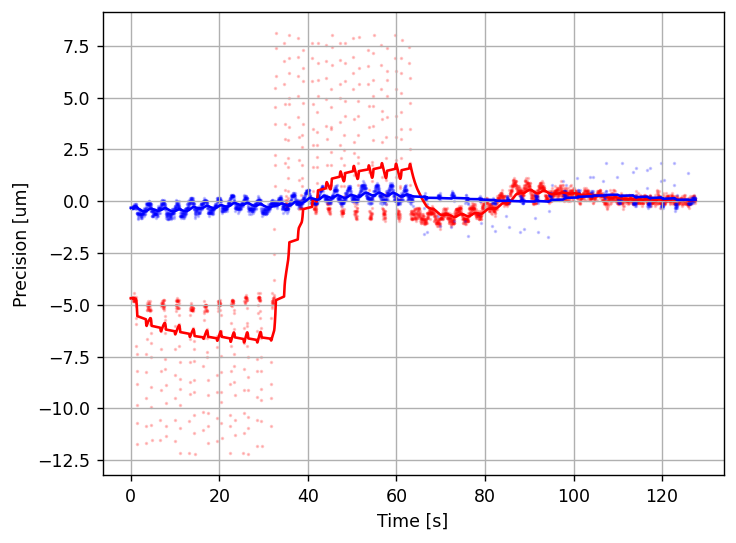

In [4]:
import sys
from PySide6 import QtWidgets
from PySide6 import QtCore
from PySide6 import QtGui
from PySide6.QtGui import *
from PySide6.QtWidgets import *
from PySide6.QtCore import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas

from scipy.fft import fft
import ctypes
myappid = 'nil.npm.pyqt.2' # arbitrary string
ctypes.windll.shell32.SetCurrentProcessExplicitAppUserModelID(myappid)
import warnings
warnings.filterwarnings("ignore")

from importlib import reload
import ui_grapher
reload(ui_grapher)
from ui_grapher import *

class MplCanvas(FigureCanvas):
    def __init__(self, parent=None):
        fig, self.ax = plt.subplots(figsize=(5, 4))  # You can set the figure size here
        super().__init__(fig)
        
        # Plot voltage vs time
        self.ax.set_xlabel('Time [s]')
        self.ax.set_ylabel('Precision [um]')
        self.ax.grid()

    def savePlot(self, filename):
        self.figure.savefig(filename)  # Save the figure to a file

class MainWindow(QtWidgets.QMainWindow, Ui_MainWindow): # main window
    def __init__(self):
        super(MainWindow, self).__init__()
        self.setupUi(self)

        self.truth=True

        self.setWindowTitle("Plotter")

        # Create and add the Matplotlib canvas to the layout
        self.canvas = MplCanvas(self)
        self.plotLayout.addWidget(self.canvas)

        df = pd.read_csv("30 step_data.csv")
        self.tx, self.x, self.x_f, x_err, self.ty, self.y, self.y_f, y_err = df.T.values
        
        self.x_points = self.canvas.ax.scatter(self.tx, self.x, label='x', s=1, color='red', alpha=0.2)
        self.y_points = self.canvas.ax.scatter(self.ty, self.y, label='y', s=1, color='blue', alpha=0.2)
        self.x_f_line, = self.canvas.ax.plot(self.tx, self.x_f, label='x_f', color='red')
        self.y_f_line, = self.canvas.ax.plot(self.ty, self.y_f, label='y_f', color='blue')
        
        self.bSlider.valueChanged.connect(self.onBSlider)
        self.tSlider.valueChanged.connect(self.onTSlider)
        self.rSlider.valueChanged.connect(self.onRSlider)
        
        self.timer = QTimer()
        self.timer.timeout.connect(self.updateGraph)
        self.timer.start(33)

        self.actionSave.triggered.connect(self.onSave)

    def onSave(self):
        self.canvas.savePlot('measurements vs simulation.png')

    def onBSlider(self):
        self.bValue.setValue(self.bSlider.value())
        
    def onTSlider(self):
        self.tValue.setValue(self.tSlider.value()/1e14)

    def onRSlider(self):
        self.rValue.setValue(self.rSlider.value()/1e12)
    
    def kalmanFilter(self, data):
        # Kalman filter parameters
        n_iter = len(data)
        z = data

        # Allocate space for arrays
        x = np.zeros(n_iter)
        P = np.zeros(n_iter)
        x[0] = 0
        P[0] = 1

        Q = self.tValue.value()  # Process noise covariance
        R = self.rValue.value()    # Measurement noise covariance

        # Kalman filter algorithm
        for k in range(1, n_iter):
            x_pred = x[k-1]
            P_pred = P[k-1] + Q

            K = P_pred / (P_pred + R)
            x[k] = x_pred + K * (z[k] - x_pred)
            P[k] = (1 - K) * P_pred

        return x

    def unscentedKalmanFilter(self, data):
        # UKF Parameters
        n_iter = len(data)
        z = data

        # Allocate space for arrays
        x = np.zeros(n_iter)  # State estimate
        P = np.zeros(n_iter)  # Estimate covariance
        x[0] = 0  # Initial state
        P[0] = 1  # Initial covariance

        # Process and measurement noise covariance
        Q = self.tValue.value()  # Process noise covariance from slider
        R = self.rValue.value()  # Measurement noise covariance from slider

        # UKF Algorithm
        for k in range(1, n_iter):
            # Prediction Step
            x_pred = x[k - 1]  # In UKF, this would come from a non-linear model
            P_pred = P[k - 1] + Q  # Update covariance with process noise

            # Measurement Update (Correction Step)
            K = P_pred / (P_pred + R)  # Kalman Gain
            x[k] = x_pred + K * (z[k] - x_pred)  # Update state estimate
            P[k] = (1 - K) * P_pred  # Update estimate covariance

        return x
    
    def updateGraph(self):
        # Sample time and noisy velocity data (replace with your data)
        length = int(max(len(self.tx),len(self.ty)) * self.bValue.value() / 100)

        if length < 10:
            return  # Prevent errors with too few data points

        tx = self.tx[:length]
        ty = self.ty[:length]
        x = self.x[:length]
        y = self.y[:length]

        x_f = self.unscentedKalmanFilter(x)
        y_f = self.unscentedKalmanFilter(y)
        x_err = np.std(x_f)
        y_err = np.std(y_f)

        # Update plot data without recreating the canvas
        self.x_points.set_offsets(np.c_[tx, x])
        self.y_points.set_offsets(np.c_[ty, y])
        self.x_f_line.set_data(tx, x_f)
        self.y_f_line.set_data(ty, y_f)

        # Rescale the axes
        self.canvas.ax.relim()
        self.canvas.ax.autoscale_view()

        # Redraw the canvas
        print(f'X Precision: ±{x_err:.4f} um, Y Precision: ±{y_err:.4f} um', end='\r')
        self.canvas.draw()

    def closeEvent(self, event):
        try:
            # Perform any other necessary cleanup tasks
            event.accept()  # Accept the event to close the window
            
            super().closeEvent(event)
        except Exception as e:
            print(f"Error during close event: {e}")
            event.ignore()  # Optionally ignore the event if cleanup fails
        print('\nExited')

if not QtWidgets.QApplication.instance():
    app = QtWidgets.QApplication(sys.argv)
else:
    app = QtWidgets.QApplication.instance()

if __name__ == '__main__':
    window = MainWindow()
    app.setStyle('Windows')
    window.show()
    print('Running\n')
    app.exec()

t2: 10 step     : 100.00% : Running: False
t4: 30 step     : 100.00% : Running: False
t1: 0 step fixed : 100.00% : Running: False
t3: 20 step     : 100.00% : Running: False


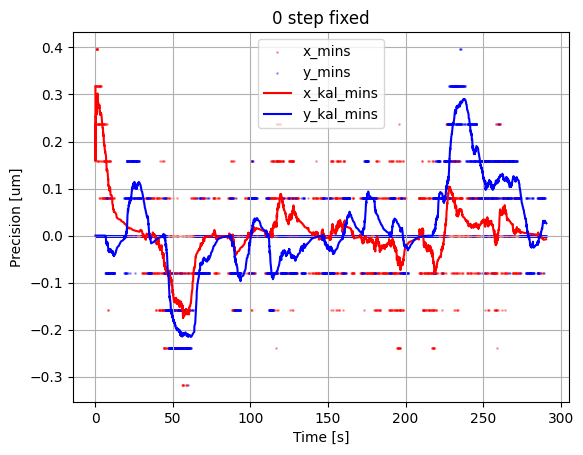

X Precision: +0.02 um, -0.02 um
Y Precision: +0.07 um, -0.03 um


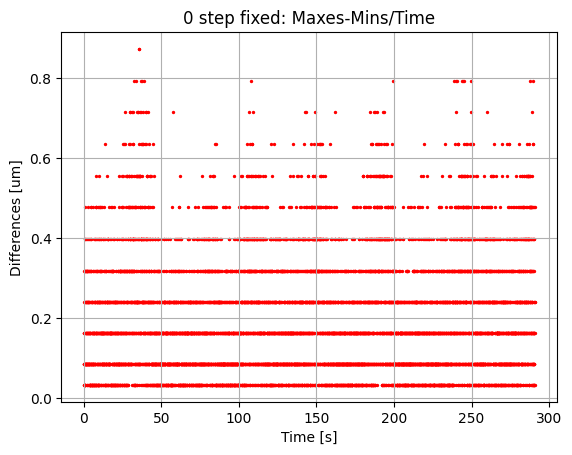

0 step fixed -- Silhouette score for 12 clusters: 1.0000                                            
0 step fixed -- Trying for 2 clusters. . .
0 step fixed -- Error: Unable to split into two optimal clusters.                                   
0 step fixed -- Best score of 1.0000 with 12 clusters: 
[[3.98222936e-01 6.03000000e+02]
 [8.60809325e-02 2.23900000e+03]
 [2.40417249e-01 1.36300000e+03]
 [6.35795033e-01 7.20000000e+01]
 [1.62192399e-01 1.81500000e+03]
 [3.19205520e-01 8.81000000e+02]
 [3.33333333e-02 1.22300000e+03]
 [4.77355717e-01 3.04000000e+02]
 [5.56554657e-01 1.72000000e+02]
 [7.15063069e-01 3.10000000e+01]
 [7.94350485e-01 1.60000000e+01]
 [8.73652005e-01 2.00000000e+00]] um)
0 step fixed -- Selecting two most populous clusters: 0.08608093246321466, 0.16219239933366977
0 step fixed -- Estimated Distance: 0.0761 um


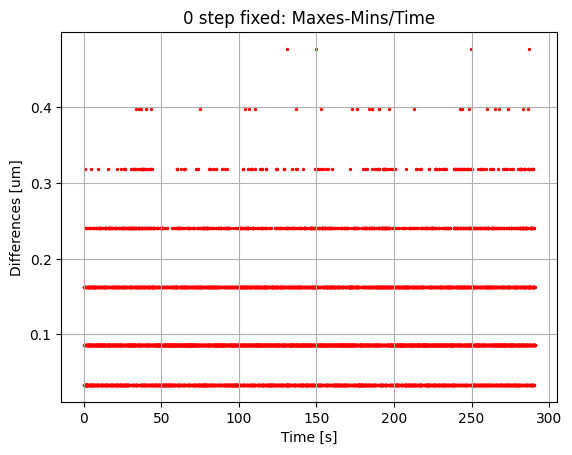

0 step fixed -- Silhouette score for 7 clusters: 1.0000                                             
0 step fixed -- Trying for 2 clusters. . .
0 step fixed -- Error: Unable to split into two optimal clusters.                                   
0 step fixed -- Best score of 1.0000 with 7 clusters: 
[[2.40417249e-01 7.88000000e+02]
 [8.60809325e-02 3.55000000e+03]
 [1.62192399e-01 2.02500000e+03]
 [3.33333333e-02 2.13600000e+03]
 [3.19205520e-01 1.87000000e+02]
 [3.98222936e-01 3.10000000e+01]
 [4.77355717e-01 4.00000000e+00]] um)
0 step fixed -- Selecting two most populous clusters: 0.08608093246321444, 0.033333333333333826
0 step fixed -- Estimated Distance: 0.0527 um

---- Processes Terminated



In [1]:
import cv2
import numpy as np
from time import *
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import threading
import psutil
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import traceback

progress_threads={}
progress_data={}
combinedFrames={}
dists={}
lock = threading.Lock()

class ClusterFilter:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps  # Maximum distance between two samples for them to be considered in the same neighborhood
        self.min_samples = min_samples  # Minimum number of points to form a cluster

    def apply_dbscan(self, x_data, y_data):
        # Combine x and y data for clustering
        data = np.vstack((x_data, y_data)).T

        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        labels = dbscan.fit_predict(data)

        cluster_mask = labels != -1
        noise_mask = labels == -1

        clustered_x = x_data[cluster_mask]
        clustered_y = y_data[cluster_mask]

        noise_x = x_data[noise_mask]
        noise_y = y_data[noise_mask]

        return clustered_x, clustered_y, noise_x, noise_y

def findClusters(data, name, max_clusters=100):
    clusters={}
    scores=[]
    for n_clusters in range(2,max_clusters):
        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always", category=UserWarning)
                kmeans = KMeans(n_clusters)
                data_reshaped = data.reshape(-1, 1)  # Reshape distances for clustering
                labels = kmeans.fit_predict(data_reshaped)

                if any(issubclass(warn.category, ConvergenceWarning) for warn in w):
                    break
                    
                counts = np.bincount(labels)
                silhouette_avg = silhouette_score(data_reshaped, labels)

                print(f'{name} -- Silhouette score for {n_clusters} clusters: {silhouette_avg:.4f}'.ljust(100),end='\r')
                scores.append(silhouette_avg)
                clusters[silhouette_avg]=(n_clusters, kmeans.cluster_centers_, counts)
        except:
            break
    print(f'{name} -- Silhouette score for {clusters[max(scores)][0]} clusters: {max(scores):.4f}'.ljust(100),end='\r')
    return clusters, scores

def clusterizeData(t_maxes, maxes, t_mins, mins, name):
    x1 = np.array(t_maxes)
    y1 = np.array(maxes)
    x2 = np.array(t_mins)
    y2 = np.array(mins)
    name = name
    
    combinedX = np.concatenate((x1, x2))
    combinedY = np.concatenate((y1, y2))
    
    sorted_indices = np.argsort(combinedX)
    x_sorted = combinedX[sorted_indices]
    y_sorted = combinedY[sorted_indices]
    
    x_diff = np.diff(x_sorted)
    y_diff = np.diff(y_sorted)
    distances = np.sqrt(x_diff**2 + y_diff**2)
    
    plt.figure()
    plt.scatter(x_sorted[:len(distances)], distances, s=2, color='red')
    plt.xlabel('Time [s]')
    plt.ylabel("Differences [um]")
    plt.title(f'{name}: Maxes-Mins/Time')
    plt.grid()
    plt.show()
    
    clusters, scores = findClusters(distances, name)
    print(f'\n{name} -- Trying for 2 clusters. . .')
    while clusters[max(scores)][0] > 2:
        temp=(scores[:],clusters)
        clusters, scores = findClusters(data=clusters[max(scores)][1], name=name)
        if not scores or max(scores) < 0.8:
            scores=temp[0]
            clusters=temp[1]
            break
            
    bestCluster = clusters[max(scores)]
    dist=np.nan
    if bestCluster[0] > 2:
        print(f'{name} -- Error: Unable to split into two optimal clusters.')
        print(f'{name} -- Best score of {max(scores):.4f} with {bestCluster[0]} clusters: \n{np.column_stack((bestCluster[1].flatten(),bestCluster[2]))} um)')
        sort=np.argsort(-bestCluster[2])
        print(f'{name} -- Selecting two most populous clusters: {bestCluster[1][sort][0][0]}, {bestCluster[1][sort][1][0]}')
        dist=np.abs(bestCluster[1][sort][0][0]-bestCluster[1][sort][1][0])
        print(f'{name} -- Estimated Distance: {dist:.4f} um')
    else:
        dist=np.abs(bestCluster[1][0][0]-bestCluster[1][1][0])
        print(f'\n{name} -- Best score of {max(scores):.4f} with {bestCluster[0]} clusters: {dist:.4f} um')
    return dist

def findMedianZero(time, data):
    initial = [time[1] - time[0]]
    index = []
    indexedData = []
    for i in range(1,len(time)):
        diff = np.abs(time[i] - time[i-1])
        if diff > np.median(initial)*1.05:
            break
        initial.append(diff)
        index.append(i)
    for i in index:
        indexedData.append(data[i])
    return np.median(indexedData)

def splitClusters(time, data, blockSize=100):
    mins=[]
    maxes=[]
    for i in range(0,len(data)-blockSize):
        movAvg = np.average(data[i:blockSize+i])
        if np.abs(data[i]) <= np.abs(movAvg):
            mins.append((time[i],data[i]))
        else:
            maxes.append((time[i],data[i]))
            
    return mins, maxes

def kalmanFilterFunc(data):
    # Kalman filter parameters
    n_iter = len(data)
    z = data

    # Allocate space for arrays
    x = np.zeros(n_iter)
    P = np.zeros(n_iter)
    x[0] = z[0]
    P[0] = 1

    Q = 0.0000001  # Process noise covariance
    R = 0.0001  # Measurement noise covariance

    # Kalman filter algorithm
    for k in range(1, n_iter):
        x_pred = x[k-1]
        P_pred = P[k-1] + Q

        K = P_pred / (P_pred + R)
        x[k] = x_pred + K * (z[k] - x_pred)
        P[k] = (1 - K) * P_pred

    return x
  
def dataStatistics(datax, datay, name, blockSize=100, kalman=True, mins=True, maxes=False, rawData=False, show_x=True, show_y=True):
    if not any([kalman, mins, maxes, rawData]):
        print('Must select data to display!')
        return
    
    tx, x = zip(*datax)
    ty, y = zip(*datay)
    tx = np.unique(np.array(tx))/30
    ty = np.unique(np.array(ty))/30
    x = np.array(x)[:len(tx)]/12.6
    y = np.array(y)[:len(ty)]/12.6
    
    cluster_filter = ClusterFilter(eps=0.5, min_samples=10)
    tx_cluster, x_cluster, tx, x = cluster_filter.apply_dbscan(tx, x)
    ty_cluster, y_cluster, ty, y = cluster_filter.apply_dbscan(ty, y)
    
    while True:
        median = findMedianZero(tx_cluster, x_cluster)
        if np.abs(median) >= 0.00001:
            x_cluster = x_cluster - 0.5*median
            x = x - 0.5*median
            #print(f'x_median: {median}', end='\r')
        else:
            #print(f'x_median: {median}')
            break
    
    while True:
        median=findMedianZero(ty_cluster, y_cluster)
        if np.abs(median) >= 0.00001:
            y_cluster = y_cluster - 0.5*median
            y = y - 0.5*median
            #print(f'y_median: {median}', end='\r')
        else:
            #print(f'y_median: {median}')
            break

    x_mins, x_maxes = splitClusters(tx_cluster, x_cluster, blockSize)
    y_mins, y_maxes = splitClusters(ty_cluster, y_cluster, blockSize)
    tx_filter_maxes, x_filter_maxes = zip(*x_maxes)
    ty_filter_maxes, y_filter_maxes = zip(*y_maxes)
    tx_filter_mins, x_filter_mins = zip(*x_mins)
    ty_filter_mins, y_filter_mins = zip(*y_mins)
        
    x_kalman_mins = kalmanFilterFunc(x_filter_mins)
    y_kalman_mins = kalmanFilterFunc(y_filter_mins)

    x_kalman_maxes = kalmanFilterFunc(x_filter_maxes)
    y_kalman_maxes = kalmanFilterFunc(y_filter_maxes)
    
    plt.figure()

    if rawData:
        if show_x:
            plt.scatter(tx, x, label='x', s=1, color='red', alpha=0.2)
        if show_y:
            plt.scatter(ty, y, label='y', s=1, color='blue', alpha=0.2)
    if mins:
        if show_x:
            plt.scatter(tx_filter_mins, x_filter_mins, label='x_mins', s=1, color='red', alpha=0.3)
        if show_y:
            plt.scatter(ty_filter_mins, y_filter_mins, label='y_mins', s=1, color='blue', alpha=0.3)
    if maxes:
        if show_x:
            plt.scatter(tx_filter_maxes, x_filter_maxes, label='x_maxes', s=1, color='orange', alpha=0.3)
        if show_y:
            plt.scatter(ty_filter_maxes, y_filter_maxes, label='y_maxes', s=1, color='cyan', alpha=0.3)
    if kalman:
        if mins:
            if show_x:
                plt.plot(tx_filter_mins, x_kalman_mins, label='x_kal_mins', color='red')
            if show_y:
                plt.plot(ty_filter_mins, y_kalman_mins, label='y_kal_mins', color='blue')
        if maxes:
            if show_x:
                plt.plot(tx_filter_maxes, x_kalman_maxes, label='x_kal_maxes', color='orange')
            if show_y:
                plt.plot(ty_filter_maxes, y_kalman_maxes, label='y_kal_maxes', color='cyan')
            
    plt.grid()
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel("Precision [um]")
    plt.title(name)
    plt.savefig(name)
    plt.show()
    
    x_err = (np.median(x_kalman_mins[x_kalman_mins >= 0]),np.median(x_kalman_mins[x_kalman_mins < 0]))
    sign=''
    if np.median(x_err[1]) > 0: 
        sign = "+"
    print(f'X Precision: +{x_err[0]:.2f} um, {sign}{x_err[1]:.2f} um')
    
    y_err = (np.median(y_kalman_mins[y_kalman_mins >= 0]),np.median(y_kalman_mins[y_kalman_mins < 0]))
    sign=''
    if np.median(y_err[1]) > 0: 
        sign = "+"
    print(f'Y Precision: +{y_err[0]:.2f} um, {sign}{y_err[1]:.2f} um')

    maxLength = max(
        len(tx),
        len(x),
        len(ty),
        len(y),
        len(tx_filter_mins),
        len(x_filter_mins),
        len(ty_filter_mins),
        len(y_filter_mins),
        len(tx_filter_maxes),
        len(x_filter_maxes),
        len(ty_filter_maxes),
        len(y_filter_maxes),
        len(x_kalman_mins),
        len(y_kalman_mins),
        len(x_kalman_maxes),
        len(y_kalman_maxes)
    )
    
    def padList(lst, maxLength):
        lst = list(lst)
        return lst+ [None] * (maxLength - len(lst))
    
    df = pd.DataFrame({
        'tx': padList(tx_filter_mins, maxLength),
        'x': padList(x_filter_mins, maxLength),
        'ty': padList(ty_filter_mins, maxLength),
        'y': padList(y_filter_mins, maxLength),
        'tx_max': padList(tx_filter_maxes, maxLength),
        'x_max': padList(x_filter_maxes, maxLength),
        'ty_max': padList(ty_filter_maxes, maxLength),
        'y_max': padList(y_filter_maxes, maxLength),
        'x_kalman_min': padList(x_kalman_mins, maxLength),
        'y_kalman_min': padList(y_kalman_mins, maxLength),
        'x_kalman_max': padList(x_kalman_maxes, maxLength),
        'y_kalman_max': padList(y_kalman_maxes, maxLength),
        'x_err': padList(x_err, maxLength),
        'y_err': padList(y_err, maxLength),
    })
    df.to_csv(f'{name}_data.csv', sep=',', index=False, header=True)

    returnData = {
        "name":name,
        "tx": tx,
        "x": x,
        "ty": ty,
        "y": y,
        "tx_filter_mins": tx_filter_mins,
        "x_filter_mins": x_filter_mins,
        "ty_filter_mins": ty_filter_mins,
        "y_filter_mins": y_filter_mins,
        "tx_filter_maxes": tx_filter_maxes,
        "x_filter_maxes": x_filter_maxes,
        "ty_filter_maxes": ty_filter_maxes,
        "y_filter_maxes": y_filter_maxes,
        "x_kalman_mins": x_kalman_mins,
        "y_kalman_mins": y_kalman_mins,
        "x_kalman_maxes": x_kalman_maxes,
        "y_kalman_maxes": y_kalman_maxes
    }

    return returnData

def preCheck(search_region, roi, threshold=0.05, scale=0.1):
    reducedRegion = cv2.resize(search_region, (0, 0), fx=scale, fy=scale)
    reducedROI = cv2.resize(roi, (0, 0), fx=scale, fy=scale)

    res = cv2.matchTemplate(reducedRegion, reducedROI, cv2.TM_SQDIFF_NORMED)
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
    
    if minVal <= threshold:
        return True, 1 / (1 + np.abs(minVal))
    else:
        return False, 1 / (1 + np.abs(minVal))

def textBackground(text, fontScale, thickness, pos):
    (textWidth, textHeight), baseline = cv2.getTextSize(str(text), cv2.FONT_HERSHEY_SIMPLEX, fontScale, thickness)
    rect = [(pos[0], pos[1]), (pos[0] + textWidth, pos[1] + textHeight+baseline)]
    textPos = (pos[0], pos[1] + textHeight + baseline // 2)
    
    return (rect, textPos)

def analyzeVideo(thread, files, confidence):
    global progress_threads
    global progress_data
    global combinedFrames
    global dists
    with lock:
        progress_threads[thread]=True

    def drawROI(frame, frameCount, topLeft, bottomRight, maxVal, color, text):
        cv2.rectangle(frame, topLeft, bottomRight, color, 2)
        msgConf = f'Confidence : {maxVal:.3f}'
        posConf=(5, 60) 
        fontScale = 1.5
        thickness = 2
        rectConf, posConf = textBackground(msgConf, fontScale, thickness, posConf)
        cv2.rectangle(frame, rectConf[0], rectConf[1], color=(255, 255, 255), thickness=-1)
        cv2.putText(frame, msgConf, posConf, cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0,0,0), thickness, lineType=cv2.LINE_AA)
        cv2.putText(frame, text, (topLeft[0],topLeft[1]+30), cv2.FONT_HERSHEY_SIMPLEX, fontScale, color, thickness, lineType=cv2.LINE_AA)
        
        roi_center_x = (topLeft[0] + bottomRight[0]) // 2
        roi_center_y = (topLeft[1] + bottomRight[1]) // 2
    
        datax.append((frameCount, roi_center_x))
        datay.append((frameCount, roi_center_y))
    
    for file in files:
        videoName = file
        name=videoName.split('/')[-1].split('.')[0]
        cap = cv2.VideoCapture(videoName)
        ret, frame = cap.read()
        height, width, channel = frame.shape
        fps = cap.get(cv2.CAP_PROP_FPS)
        delay = 1/fps
        t1=0
        t2=0
        frame1=0
        frame2=0
        startPoint = (-1, -1)
        endPoint = (-1, -1)
        
        datax=[]
        datay=[]
        grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, grayFrame = cv2.threshold(grayFrame, 128, 255, cv2.THRESH_BINARY)
        roiW = int(width*0.2)
        roiH = int(height*0.2)
        topLeft = ((width - roiW) // 2, (height - roiH) // 2)
        bottomRight = (topLeft[0] + roiW, topLeft[1] + roiH)
        roi = grayFrame[topLeft[1]:bottomRight[1], topLeft[0]:bottomRight[0]]
        roiRect=(topLeft,bottomRight)
        
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frameCount = cap.get(cv2.CAP_PROP_POS_FRAMES)
                with lock:
                    progress_data[f'{thread}: {name}']=f'{frameCount/int(cap.get(cv2.CAP_PROP_FRAME_COUNT))*100:.2f}%'
                    # if frameCount/int(cap.get(cv2.CAP_PROP_FRAME_COUNT))*100 > 10:
                    #     break
                    
                grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Update gray frame
                _, grayFrame = cv2.threshold(grayFrame, 128, 255, cv2.THRESH_BINARY)
                
                # Ensure the current ROI size is smaller than the frame size
                if roi is not None and grayFrame.shape[0] >= roi.shape[0] and grayFrame.shape[1] >= roi.shape[1] and bottomRight and topLeft:
                    expand_size = 50
                    search_topLeft_x = max(topLeft[0] - expand_size, 0)
                    search_topLeft_y = max(topLeft[1] - expand_size, 0)
                    search_bottomRight_x = min(bottomRight[0] + expand_size, grayFrame.shape[1])
                    search_bottomRight_y = min(bottomRight[1] + expand_size, grayFrame.shape[0])
                    search_region = grayFrame[search_topLeft_y:search_bottomRight_y, search_topLeft_x:search_bottomRight_x]
                    cv2.rectangle(frame, (search_topLeft_x,search_topLeft_y), (search_bottomRight_x,search_bottomRight_y), color=(255, 0, 255), thickness=2)
                    cv2.putText(frame, 'search_region', (search_topLeft_x,search_topLeft_y-5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), 2, lineType=cv2.LINE_AA)
                    cv2.rectangle(frame, roiRect[0], roiRect[1], color=(255, 255, 0), thickness=2)
                    cv2.putText(frame, 'roi', (roiRect[0][0], roiRect[0][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 2, lineType=cv2.LINE_AA)
                    
                    # Perform template matching in the smaller region
                    searched = False
                    framed = False
                    framedVal=0
                    searchVal=0
                    if search_region.shape[0] >= roi.shape[0] and search_region.shape[1] >= roi.shape[1]:
                        searched, searchVal = preCheck(search_region, roi)
                        if searched:
                            cv2.putText(frame, f's: {searchVal:.3f}', (roiRect[0][0],roiRect[1][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 2, lineType=cv2.LINE_AA)
                        else:
                            framed, framedVal = preCheck(grayFrame, roi)
                            if framed:
                                cv2.putText(frame, f's: {searchVal:.3f}, f: {framedVal:.3f}', (roiRect[0][0],roiRect[1][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 2, lineType=cv2.LINE_AA)
                        if any([searched,framed]):    
                            res = cv2.matchTemplate(search_region, roi, cv2.TM_SQDIFF_NORMED)
                            minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
                            val = 1 / (1 + np.abs(minVal))
                            if minVal <= confidence:
                                topLeft = (minLoc[0] + search_topLeft_x, minLoc[1] + search_topLeft_y)
                                bottomRight = (topLeft[0] + roiW, topLeft[1] + roiH)
            
                                if bottomRight[1] <= grayFrame.shape[0] and bottomRight[0] <= grayFrame.shape[1] and minVal <= confidence:
                                    color=(0,255,0)
                                    text='search'
                                    drawROI(frame, frameCount, topLeft, bottomRight, val, color, text)
                            elif minVal <= 0.2: # try frame if search_region fails given some margin
                                res = cv2.matchTemplate(grayFrame, roi, cv2.TM_SQDIFF_NORMED)
                                minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
                                #minVal, minLoc = normalized_fourier_match(search_region, roi)
                                if minVal <= confidence:
                                    topLeft = minLoc
                                    bottomRight = (topLeft[0] + roiW, topLeft[1] + roiH)
                                    val = 1 / (1 + np.abs(minVal))
            
                                    if bottomRight[1] <= grayFrame.shape[0] and bottomRight[0] <= grayFrame.shape[1]:
                                        color=(0,0,255)
                                        text='frame'
                                        drawROI(frame, frameCount, topLeft, bottomRight, val, color, text)
                    else:
                        print("ROI is too large for the search region.")
                    
                if frameCount % 2 == 0:
                    t2 = time()
                    frame2 = cap.get(cv2.CAP_PROP_POS_FRAMES)
                else:
                    t1 = time()
                    frame1 = cap.get(cv2.CAP_PROP_POS_FRAMES)
                realFPS = np.abs(int(1/(t2 - t1)))
    
                msgFPS = f'FPS : {realFPS}'
                posFPS=(5, 5) 
                fontScale = 1.5
                thickness = 2
                rectFPS, posFPS = textBackground(msgFPS, fontScale, thickness, posFPS)
                cv2.rectangle(frame, rectFPS[0], rectFPS[1], color=(255, 255, 255), thickness=-1)
                cv2.putText(frame, msgFPS, posFPS, cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0,0,0), thickness, lineType=cv2.LINE_AA)

                resizedFrame = cv2.resize(frame, (0, 0), fx=0.2, fy=0.2)
                with lock:
                    combinedFrames[thread] = resizedFrame
                #cv2.imshow(videoName, resizedFrame)
            else:
                break
        cap.release()
        #cv2.destroyAllWindows()
        with lock:
            progress_threads[thread]=False
        returnData = dataStatistics(datax, datay, name, kalman=True, mins=True, maxes=False, rawData=False, show_x=True, show_y=True)
        distx = clusterizeData(returnData['tx_filter_maxes'], returnData['x_filter_maxes'], returnData['tx_filter_mins'], returnData['x_filter_mins'], returnData['name'])
        disty = clusterizeData(returnData['ty_filter_maxes'], returnData['y_filter_maxes'], returnData['ty_filter_mins'], returnData['y_filter_mins'], returnData['name'])
        with lock:
            dists[returnData['name']]=(distx,disty)


def threaded(lst, function, arg):
    global progress_threads
    global progress_data
    global combinedFrames
    global dists
    progress_threads.clear()
    progress_data.clear()
    threads=psutil.cpu_count()-1
    thread={}
    t_num=[f't{i+1}' for i in range(threads)]
    play=True
    try:
        chunks = np.array_split(lst, threads)
        chunks = [arr for arr in chunks if arr.size > 0]
        for i in range(len(chunks)):
            thread[t_num[i]]=threading.Thread(target=function, args=(t_num[i], chunks[i], arg))
            thread[t_num[i]].start()
            print('Thread:'+t_num[i]+' starting. . .')

        while any(progress_threads.values()):
            sleep(0.01)
            with lock:
                if play:
                    try:
                        frames = list(combinedFrames.values())
                        n_frames = len(frames)
                        grid_size = np.ceil(np.sqrt(n_frames)).astype(int)
                        while len(frames) < grid_size ** 2:
                            frames.append(np.zeros_like(frames[0]))
                        rows = [np.hstack(frames[i * grid_size:(i + 1) * grid_size]) for i in range(grid_size)]
                        combined_frame = np.vstack(rows)
                        cv2.imshow("Combined Frames", combined_frame)
                        if cv2.waitKey(1) & 0xFF == ord('q'):
                            play = not play
                            cv2.destroyAllWindows()
                    except:
                        pass
            clear_output(wait=True)
            for i in progress_data:
                print(f"{i:<15} : {float(progress_data[i][:-1]):>6.2f}% : Running: {progress_threads[i.split(':')[0]]}")
        cv2.destroyAllWindows()
        
        for i in range(len(chunks)):
            thread[t_num[i]].join()  

        print('\n---- Processes Terminated\n')
    except Exception as e:
        clear_output(wait=True)
        print("An error occurred:")
        traceback.print_exc()

directoryPath = Path('data')
files = [f.as_posix() for f in directoryPath.iterdir() if f.is_file()]
my_steps=[0,10,20,30]
fileSteps=[]
for file in files:
    step = int(file.split('/')[-1].split('.')[0].split(' ')[0])
    if step in my_steps:
        fileSteps.append(file)
threaded(fileSteps, analyzeVideo, 0.05)

In [2]:
dists

{'30 step': (np.float64(25.682807316118435), np.float64(30.36843405783838)),
 '20 step': (np.float64(15.049348840610275), np.float64(19.401459462478904)),
 '10 step': (np.float64(4.239126501747086), np.float64(9.975554949866426)),
 '0 step fixed': (np.float64(0.07611146687045511),
  np.float64(0.05274759912988061))}

0        :    0.02,  -0.02 um,   0.07,  -0.03 um
10       :    0.07,  -0.11 um,   0.01,  -0.28 um
20       :    0.08,  -0.27 um,   0.26,  -0.05 um
30       :    4.65,  -0.22 um,   0.09,  -0.07 um


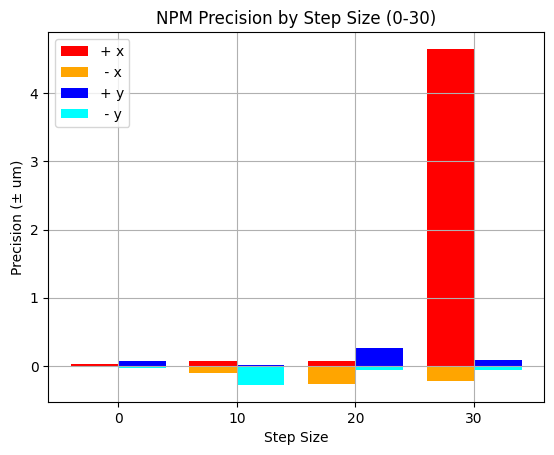

NameError: name 'returnData' is not defined

In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

name="step to um factor data"
directoryPath = Path(name)
files = [f.as_posix() for f in directoryPath.iterdir() if f.is_file()]
dataPaths = []
for file in files:
    if file.split('.')[-1] == 'csv':
        dataPaths.append(file)
dataPaths
data={}
for path in dataPaths:
    data[path.split('/')[-1].split('.')[0]]=pd.read_csv(path)

steps=[]
x_errs=[]
y_errs=[]
for i in data:
    step = i.split(' ')[0]
    steps.append(step)
    x_err = (data[i]['x_err'][0], data[i]['x_err'][1])
    x_errs.append(x_err)
    y_err = (data[i]['y_err'][0], data[i]['y_err'][1])
    y_errs.append(tuple(y_err))
    print(f"{step:<8} :  {x_err[0]:>6.2f}, {x_err[1]:>6.2f} um, {y_err[0]:>6.2f}, {y_err[1]:>6.2f} um")

x1, x2 = zip(*x_errs)
y1, y2 = zip(*y_errs)

# Create the bar chart
fig, ax = plt.subplots()
steps = np.array(steps).astype(int)
sorted_indices = np.argsort(steps)
sorted_steps = steps[sorted_indices].astype(str)
sorted_x1 = np.array(x1)[sorted_indices]
sorted_x2 = np.array(x2)[sorted_indices]
sorted_y1 = np.array(y1)[sorted_indices]
sorted_y2 = np.array(y2)[sorted_indices]

x = np.arange(len(sorted_steps))

plt.bar(x - 0.2, sorted_x1, label=f'{"+ x":>3}', color='red', width=0.4)
plt.bar(x - 0.2, sorted_x2, label=f'{"- x":>4}', color='orange', width=0.4)
plt.bar(x + 0.2, sorted_y1, label=f'{"+ y":>3}', color='blue', width=0.4)
plt.bar(x + 0.2, sorted_y2, label=f'{"- y":>4}', color='cyan', width=0.4)

# Add labels and title
plt.xlabel('Step Size')
plt.ylabel('Precision (± um)')
plt.title('NPM Precision by Step Size (0-30)')
ax.set_xticks(x)
ax.set_xticklabels(sorted_steps)
plt.legend()
plt.grid()
plt.savefig(name)

# Show the plot
plt.show()

# dx = list(zip(data['30 step_data']['tx'].dropna(),data['30 step_data']['x'].dropna()))
# dy = list(zip(data['30 step_data']['ty'].dropna(),data['30 step_data']['y'].dropna()))
# returnData = dataStatistics(dx , dy, '100 step', kalman=True, mins=True, maxes=False, rawData=False, show_x=True, show_y=True)
clusterizeData(returnData['tx_filter_maxes'], returnData['x_filter_maxes'], returnData['tx_filter_mins'], returnData['x_filter_mins'], returnData['name'])

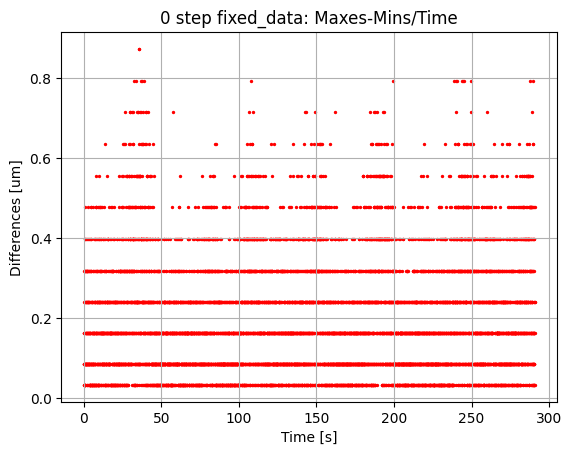

Error: name 'ConvergenceWarning' is not definedusters: 0.9852                                       
0 step fixed_data -- Silhouette score for 12 clusters: 1.0000                                       
0 step fixed_data -- Trying for 2 clusters. . .
Error: Number of labels is 12. Valid values are 2 to n_samples - 1 (inclusive)                      
0 step fixed_data -- Error: Unable to split into two optimal clusters.                              
0 step fixed_data -- Best score of 1.0000 with 12 clusters: 
[[2.40417249e-01 1.36300000e+03]
 [8.60809325e-02 2.23900000e+03]
 [4.77355717e-01 3.04000000e+02]
 [1.62192399e-01 1.81500000e+03]
 [7.15063069e-01 3.10000000e+01]
 [3.19205520e-01 8.81000000e+02]
 [3.33333333e-02 1.22300000e+03]
 [3.98222936e-01 6.03000000e+02]
 [5.56554657e-01 1.72000000e+02]
 [6.35795033e-01 7.20000000e+01]
 [7.94350485e-01 1.60000000e+01]
 [8.73652005e-01 2.00000000e+00]] um)
0 step fixed_data -- Selecting two most populous clusters: 0.08608093246321451, 0.1621

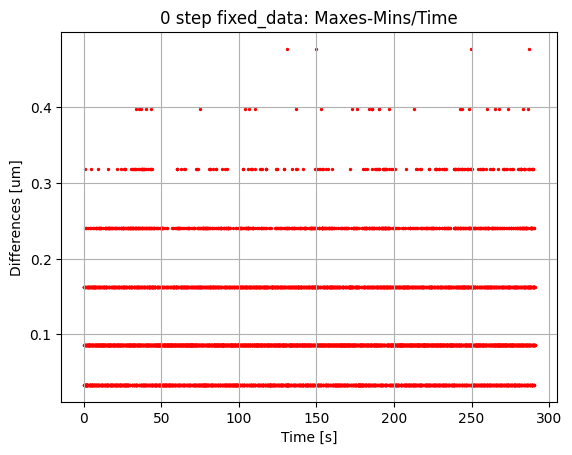

Error: name 'ConvergenceWarning' is not definedsters: 0.8918                                        
0 step fixed_data -- Silhouette score for 7 clusters: 1.0000                                        
0 step fixed_data -- Trying for 2 clusters. . .
Error: Number of labels is 7. Valid values are 2 to n_samples - 1 (inclusive)                       
0 step fixed_data -- Error: Unable to split into two optimal clusters.                              
0 step fixed_data -- Best score of 1.0000 with 7 clusters: 
[[8.60809325e-02 3.55000000e+03]
 [3.98222936e-01 3.10000000e+01]
 [1.62192399e-01 2.02500000e+03]
 [3.33333333e-02 2.13600000e+03]
 [2.40417249e-01 7.88000000e+02]
 [3.19205520e-01 1.87000000e+02]
 [4.77355717e-01 4.00000000e+00]] um)
0 step fixed_data -- Selecting two most populous clusters: 0.08608093246321437, 0.03333333333333431
0 step fixed_data -- Estimated Distance: 0.0527 um


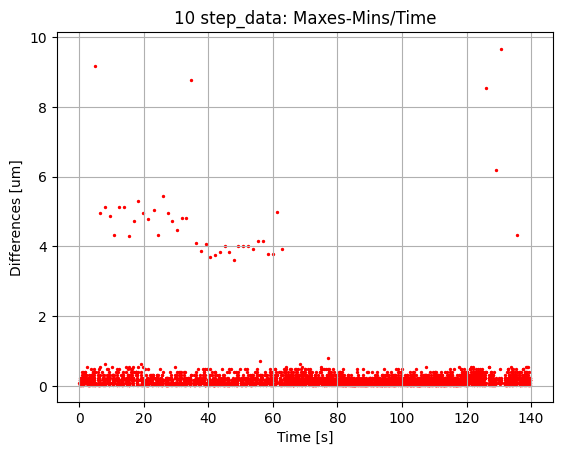

Error: name 'ConvergenceWarning' is not defineds: 0.6151                                            
10 step_data -- Silhouette score for 43 clusters: 0.9930                                            
10 step_data -- Trying for 2 clusters. . .
Error: Number of labels is 43. Valid values are 2 to n_samples - 1 (inclusive)                      
Error: Number of labels is 3. Valid values are 2 to n_samples - 1 (inclusive)                       
10 step_data -- Error: Unable to split into two optimal clusters.                                   
10 step_data -- Best score of 0.8597 with 3 clusters: 
[[ 4.53586598 20.        ]
 [ 0.30837516 19.        ]
 [ 9.03233598  4.        ]] um)
10 step_data -- Selecting two most populous clusters: 4.5358659800222725, 0.30837515574986396
10 step_data -- Estimated Distance: 4.2275 um


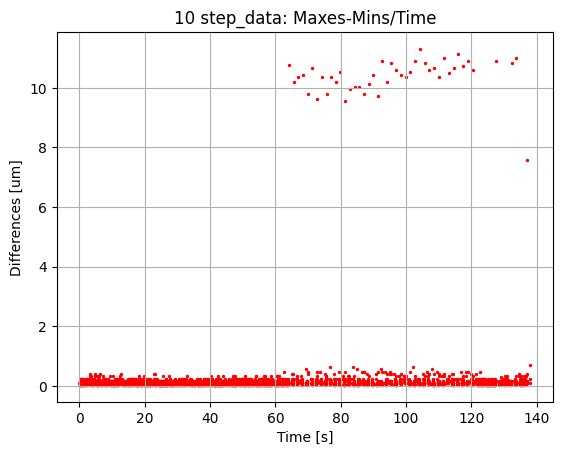

Error: name 'ConvergenceWarning' is not defineds: 0.2958                                            
10 step_data -- Silhouette score for 42 clusters: 0.9939                                            
10 step_data -- Trying for 2 clusters. . .
Error: Number of labels is 42. Valid values are 2 to n_samples - 1 (inclusive)                      
10 step_data -- Silhouette score for 2 clusters: 0.9465                                             
10 step_data -- Best score of 0.9465 with 2 clusters: 9.9756 um


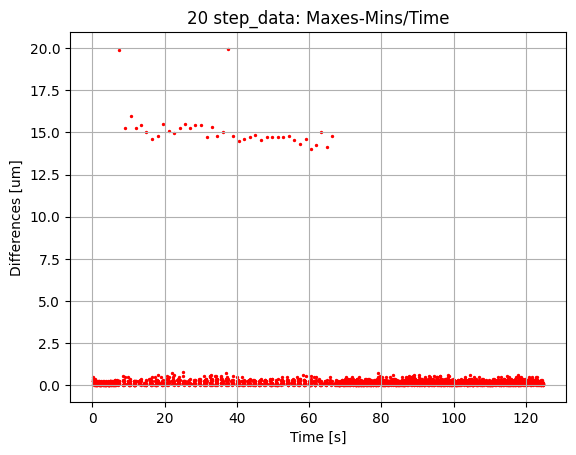

Error: name 'ConvergenceWarning' is not defineds: 0.9860                                            
20 step_data -- Silhouette score for 43 clusters: 0.9934                                            
20 step_data -- Trying for 2 clusters. . .
Error: Number of labels is 43. Valid values are 2 to n_samples - 1 (inclusive)                      
20 step_data -- Silhouette score for 2 clusters: 0.9481                                             
20 step_data -- Best score of 0.9481 with 2 clusters: 14.9979 um


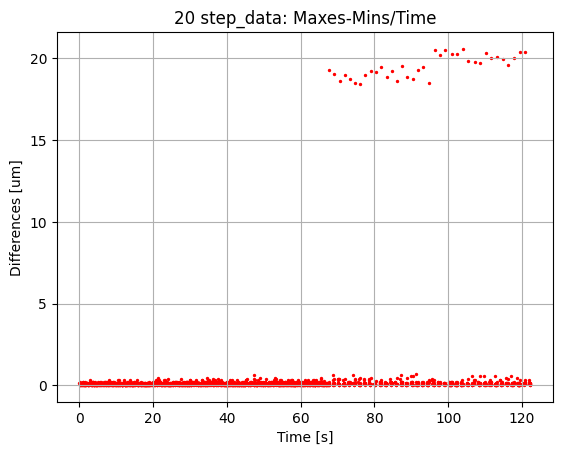

Error: name 'ConvergenceWarning' is not defineds: 0.3901                                            
20 step_data -- Silhouette score for 2 clusters: 0.9952                                             
20 step_data -- Trying for 2 clusters. . .

20 step_data -- Best score of 0.9952 with 2 clusters: 19.4015 um


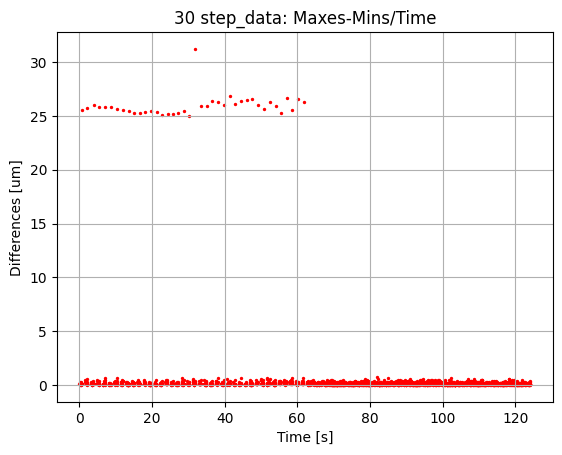

Error: name 'ConvergenceWarning' is not defineds: 0.5988                                            
30 step_data -- Silhouette score for 33 clusters: 0.9954                                            
30 step_data -- Trying for 2 clusters. . .
Error: Number of labels is 33. Valid values are 2 to n_samples - 1 (inclusive)                      
30 step_data -- Silhouette score for 2 clusters: 0.9689                                             
30 step_data -- Best score of 0.9689 with 2 clusters: 25.6828 um


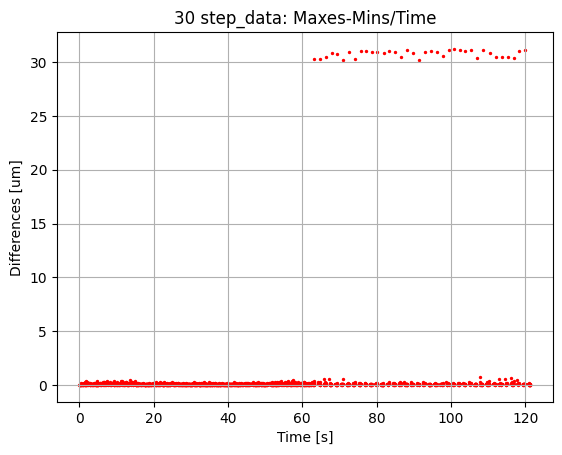

Error: name 'ConvergenceWarning' is not defineds: 0.9946                                            
30 step_data -- Silhouette score for 22 clusters: 0.9984                                            
30 step_data -- Trying for 2 clusters. . .
Error: Number of labels is 22. Valid values are 2 to n_samples - 1 (inclusive)                      
30 step_data -- Silhouette score for 2 clusters: 0.9881                                             
30 step_data -- Best score of 0.9881 with 2 clusters: 30.3565 um


In [11]:
dists={}
for i in data:
    returnData = data[i]
    distx = clusterizeData(returnData['tx_max'].dropna(), returnData['x_max'].dropna(), returnData['tx'].dropna(), returnData['x'].dropna(), i)
    disty = clusterizeData(returnData['ty_max'].dropna(), returnData['y_max'].dropna(), returnData['ty'].dropna(), returnData['y'].dropna(), i)
    dists[i]=(distx,disty)

C:\Users\Nolan\AppData\Local\Temp\ipykernel_29596\2173517194.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  slope, _ = float(model.coef_), float(model.intercept_)


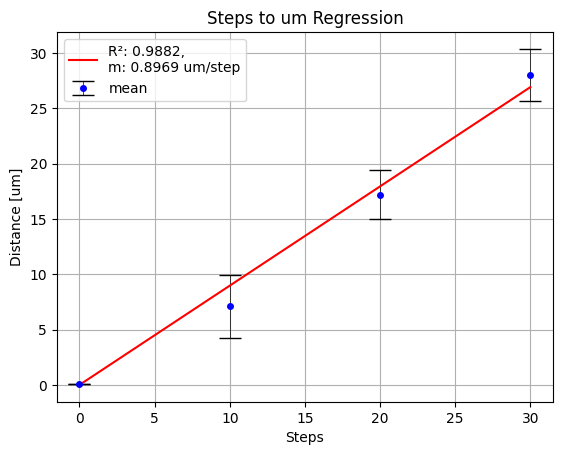

In [12]:
from sklearn.linear_model import LinearRegression

plt.figure()
x=[]
y=[]
z=[]
labels=[]
my_steps=[0,10,20,30]
for step in dists.keys():
    if int(step.split(' ')[0]) in my_steps:
        x1, y1 = dists[step]
        x.append(x1)
        y.append(y1)
        z.append(float(step.split(' ')[0]))
        labels.append(step)

x = np.array(x)[np.argsort(z)]
y = np.array(y)[np.argsort(z)]
z = np.array(z)[np.argsort(z)]
# plt.scatter(z,x,s=5,color='blue',alpha=0.5,label='raw x')
# plt.scatter(z,y,s=5,color='red',alpha=0.5,label='raw y')

uplim=[]
lowlim=[]
for i, el in enumerate(x):
    uplim.append(max(el,y[i]))
    lowlim.append(min(el,y[i]))

mean=np.mean((x,y),axis=0)
plt.errorbar(z,mean,yerr=[np.abs(uplim-mean),np.abs(lowlim-mean)],
             ecolor='black',
             label='mean',
             fmt='o',
             markersize=4,
             capsize=8,
             markerfacecolor='blue',
             markeredgecolor='blue',
             linewidth=0.5)

mean=mean.reshape(-1, 1)
z=z.reshape(-1, 1)
model = LinearRegression(fit_intercept = False).fit(z, mean)
R2 = model.score(z, mean)
slope, _ = float(model.coef_), float(model.intercept_)
plt.plot(z,z*slope,color='red',label=f'R\u00B2: {R2:.4f},\nm: {slope:.4f} um/step')
plt.legend()

plt.grid()
plt.ylabel('Distance [um]')
plt.xlabel("Steps")
plt.title('Steps to um Regression')
plt.savefig('Steps to um Regression')

In [36]:
my_steps=[0,10,20,30]
norm=[]
for i, el in enumerate(dists.values()):
    norm.append(np.array(el)/my_steps[i])
np.std(norm[1:])

C:\Users\Nolan\AppData\Local\Temp\ipykernel_29596\3315288098.py:4: RuntimeWarning: divide by zero encountered in divide
  norm.append(np.array(el)/my_steps[i])


np.float64(0.2055864650230616)